                                                I. Importation & Data Cleaning

The idea is to find a Time Serie who could be interesting to work with.

In [232]:
import pandas as pd
import numpy as np
import math
import warnings
import scipy
from datetime import timedelta
import matplotlib.dates as mdates

# for manipulate json
import json 
from pandas.io.json import json_normalize


# Forecasting 
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# For marchine Learning Approach
from statsmodels.tsa.tsatools import lagmat
#from sklearn.linear_model import LinearRegression, RidgeCV
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf

# For neural network Approach Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import multi_gpu_model

# For neural network Approach Prophet Facebook
from fbprophet import Prophet

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


- Transform flatten data from Json

In [216]:
# open sample file
with open('sample.txt') as f:
    train=json.load(f)

    
train_flattened=json_normalize(data=train)

# clear dot columns 'id.column' -> 'column'
train_flattened.columns=train_flattened.columns.map(lambda x:x.split(".")[-1])
train_flattened=train_flattened.rename(columns = {'$date':'dates','$numberLong':'numberLong'})

# count records by days
train_flattened['dates'] = pd.to_datetime(train_flattened['dates'])
train_flattened['weekend'] = ((train_flattened.dates.dt.dayofweek) // 5 == 1).astype(float)

In [182]:
# Unroll datetime by day of week
train_flattened['weekday'] = train_flattened['dates'].apply(lambda x: x.weekday())

# Feature engineering with the datetime
train_flattened['year']=train_flattened.dates.dt.year 
train_flattened['month']=train_flattened.dates.dt.month 
train_flattened['day']=train_flattened.dates.dt.day
train_flattened['hour']=train_flattened.dates.dt.hour
train_flattened

,valorTotal,dets,cnpj,fone,uf,xBairro,xLgr,xMun,xPais,xFant,...,vpis,vst,versaoDocumento,numberLong,weekend,weekday,year,month,day,hour
0,24.90,"[{u'prod': {u'xProd': u'AGUA', u'vProd': 3.5, ...",01.234.567/0001-89,1-650-933-4902,CA,,650 Castro St. unit 210,Mountain View,United States,TOTVS Labs,...,0.0,0.0,1.0,NaN,0.0,1,2016,1,5,12
1,92.53,"[{u'prod': {u'xProd': u'BUFFET', u'vProd': 83....",01.234.567/0001-89,1-650-933-4902,CA,,650 Castro St. unit 210,Mountain View,United States,TOTVS Labs,...,0.0,0.0,1.0,NaN,0.0,1,2016,1,5,12
2,57.86,"[{u'prod': {u'xProd': u'SUCO', u'vProd': 4.5, ...",01.234.567/0001-89,1-650-933-4902,CA,,650 Castro St. unit 210,Mountain View,United States,TOTVS Labs,...,0.0,0.0,1.0,NaN,0.0,1,2016,1,5,12
3,34.97,"[{u'prod': {u'xProd': u'BUFFET', u'vProd': 34....",01.234.567/0001-89,1-650-933-4902,CA,,650 Castro St. unit 210,Mountain View,United States,TOTVS Labs,...,0.0,0.0,1.0,NaN,0.0,1,2016,1,5,12
4,46.23,"[{u'prod': {u'xProd': u'BUFFET', u'vProd': 46....",01.234.567/0001-89,1-650-933-4902,CA,,650 Castro St. unit 210,Mountain View,United States,TOTVS Labs,...,0.0,0.0,1.0,NaN,0.0,1,2016,1,5,12
5,32.76,"[{u'prod': {u'xProd': u'BUFFET', u'vProd': 28....",01.234.567/0001-89,1-650-933-4902,CA,,650 Castro St. unit 210,Mountain View,United States,TOTVS Labs,...,0.0,0.0,1.0,NaN,0.0,1,2016,1,5,12
6,57.11,"[{u'prod': {u'xProd': u'AGUA', u'vProd': 3.5, ...",01.234.567/0001-89,1-650-933-4902,CA,,650 Castro St. unit 210,Mountain View,United States,TOTVS Labs,...,0.0,0.0,1.0,NaN,0.0,1,2016,1,5,12
7,36.19,"[{u'prod': {u'xProd': u'BUFFET', u'vProd': 31....",01.234.567/0001-89,1-650-933-4902,CA,,650 Castro St. unit 210,Mountain View,United States,TOTVS Labs,...,0.0,0.0,1.0,NaN,0.0,1,2016,1,5,12
8,32.37,"[{u'prod': {u'xProd': u'BUFFET', u'vProd': 32....",01.234.567/0001-89,1-650-933-4902,CA,,650 Castro St. unit 210,Mountain View,United States,TOTVS Labs,...,0.0,0.0,1.0,NaN,0.0,1,2016,1,5,12
9,119.47,"[{u'prod': {u'xProd': u'CHA', u'vProd': 3.0, u...",01.234.567/0001-89,1-650-933-4902,CA,,650 Castro St. unit 210,Mountain View,United States,TOTVS Labs,...,0.0,0.0,1.0,NaN,0.0,1,2016,1,5,12


                                                    II. Aggregation & Visualisation

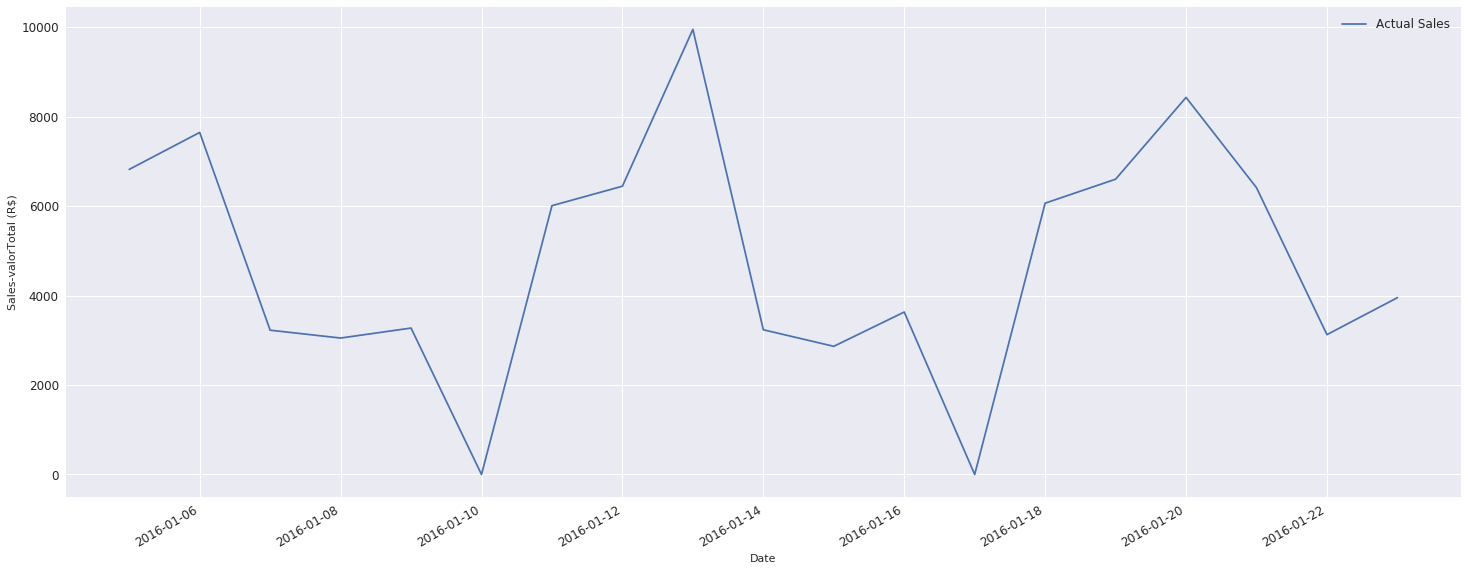

In [184]:

# Get  data to plot total sales(valorTotal) by one day
valorhour_group = train_flattened[['dates','valorTotal']]

# Set the datetime column as the index
valorhour_group.index = valorhour_group['dates']

# Get total value of sales by day 'd' (can be by hour 'h') 
valorhour_group=valorhour_group.resample('d').sum()
valorhour_group_viz = valorhour_group.reset_index()
valorhour_group_viz = valorhour_group_viz .rename(columns = {'dates':'ds'})
valorhour_group_viz.set_index('ds',inplace=True)

# plot times series of daily sales restaurant 
fig, ax = plt.subplots(figsize=(25, 10))
ax.plot(valorhour_group_viz,label='Actual Sales')
fig.autofmt_xdate()
ax.set_ylabel('Sales-valorTotal (R$)')
ax.set_xlabel('Date')

# change size font
ax.tick_params(axis='both',which='both',labelsize='large')

# change the legend text
L=ax.legend(fontsize='large') #get the legend
L.get_texts()[0].set_text('Actual Sales') #change the legend text for 1st plot

    


In order to get more visual analysis, follow codes create heatmaps can help us to find patterns, with daily or hourly timestep data

In [185]:
# For the next graphics
train_flattened['month_num'] = train_flattened['month']

# set data only to january because dataset size
train_flattened['month'].replace('1','1 - January',inplace=True)

# replace weekday value by weekday value-name
train_flattened['weekday_num'] = train_flattened['weekday']
train_flattened['weekday'].replace(0,'01 - Monday',inplace=True)
train_flattened['weekday'].replace(1,'02 - Tuesday',inplace=True)
train_flattened['weekday'].replace(2,'03 - Wednesday',inplace=True)
train_flattened['weekday'].replace(3,'04 - Thursday',inplace=True)
train_flattened['weekday'].replace(4,'05 - Friday',inplace=True)
train_flattened['weekday'].replace(5,'06 - Saturday',inplace=True)
train_flattened['weekday'].replace(6,'07 - Sunday',inplace=True)

In [186]:
train_group = train_flattened.groupby(["month", "weekday"])
train_group = train_group['valorTotal'].mean().reset_index()
train_group = train_group.pivot('weekday','month','valorTotal')
train_group.sort_index(inplace=True)

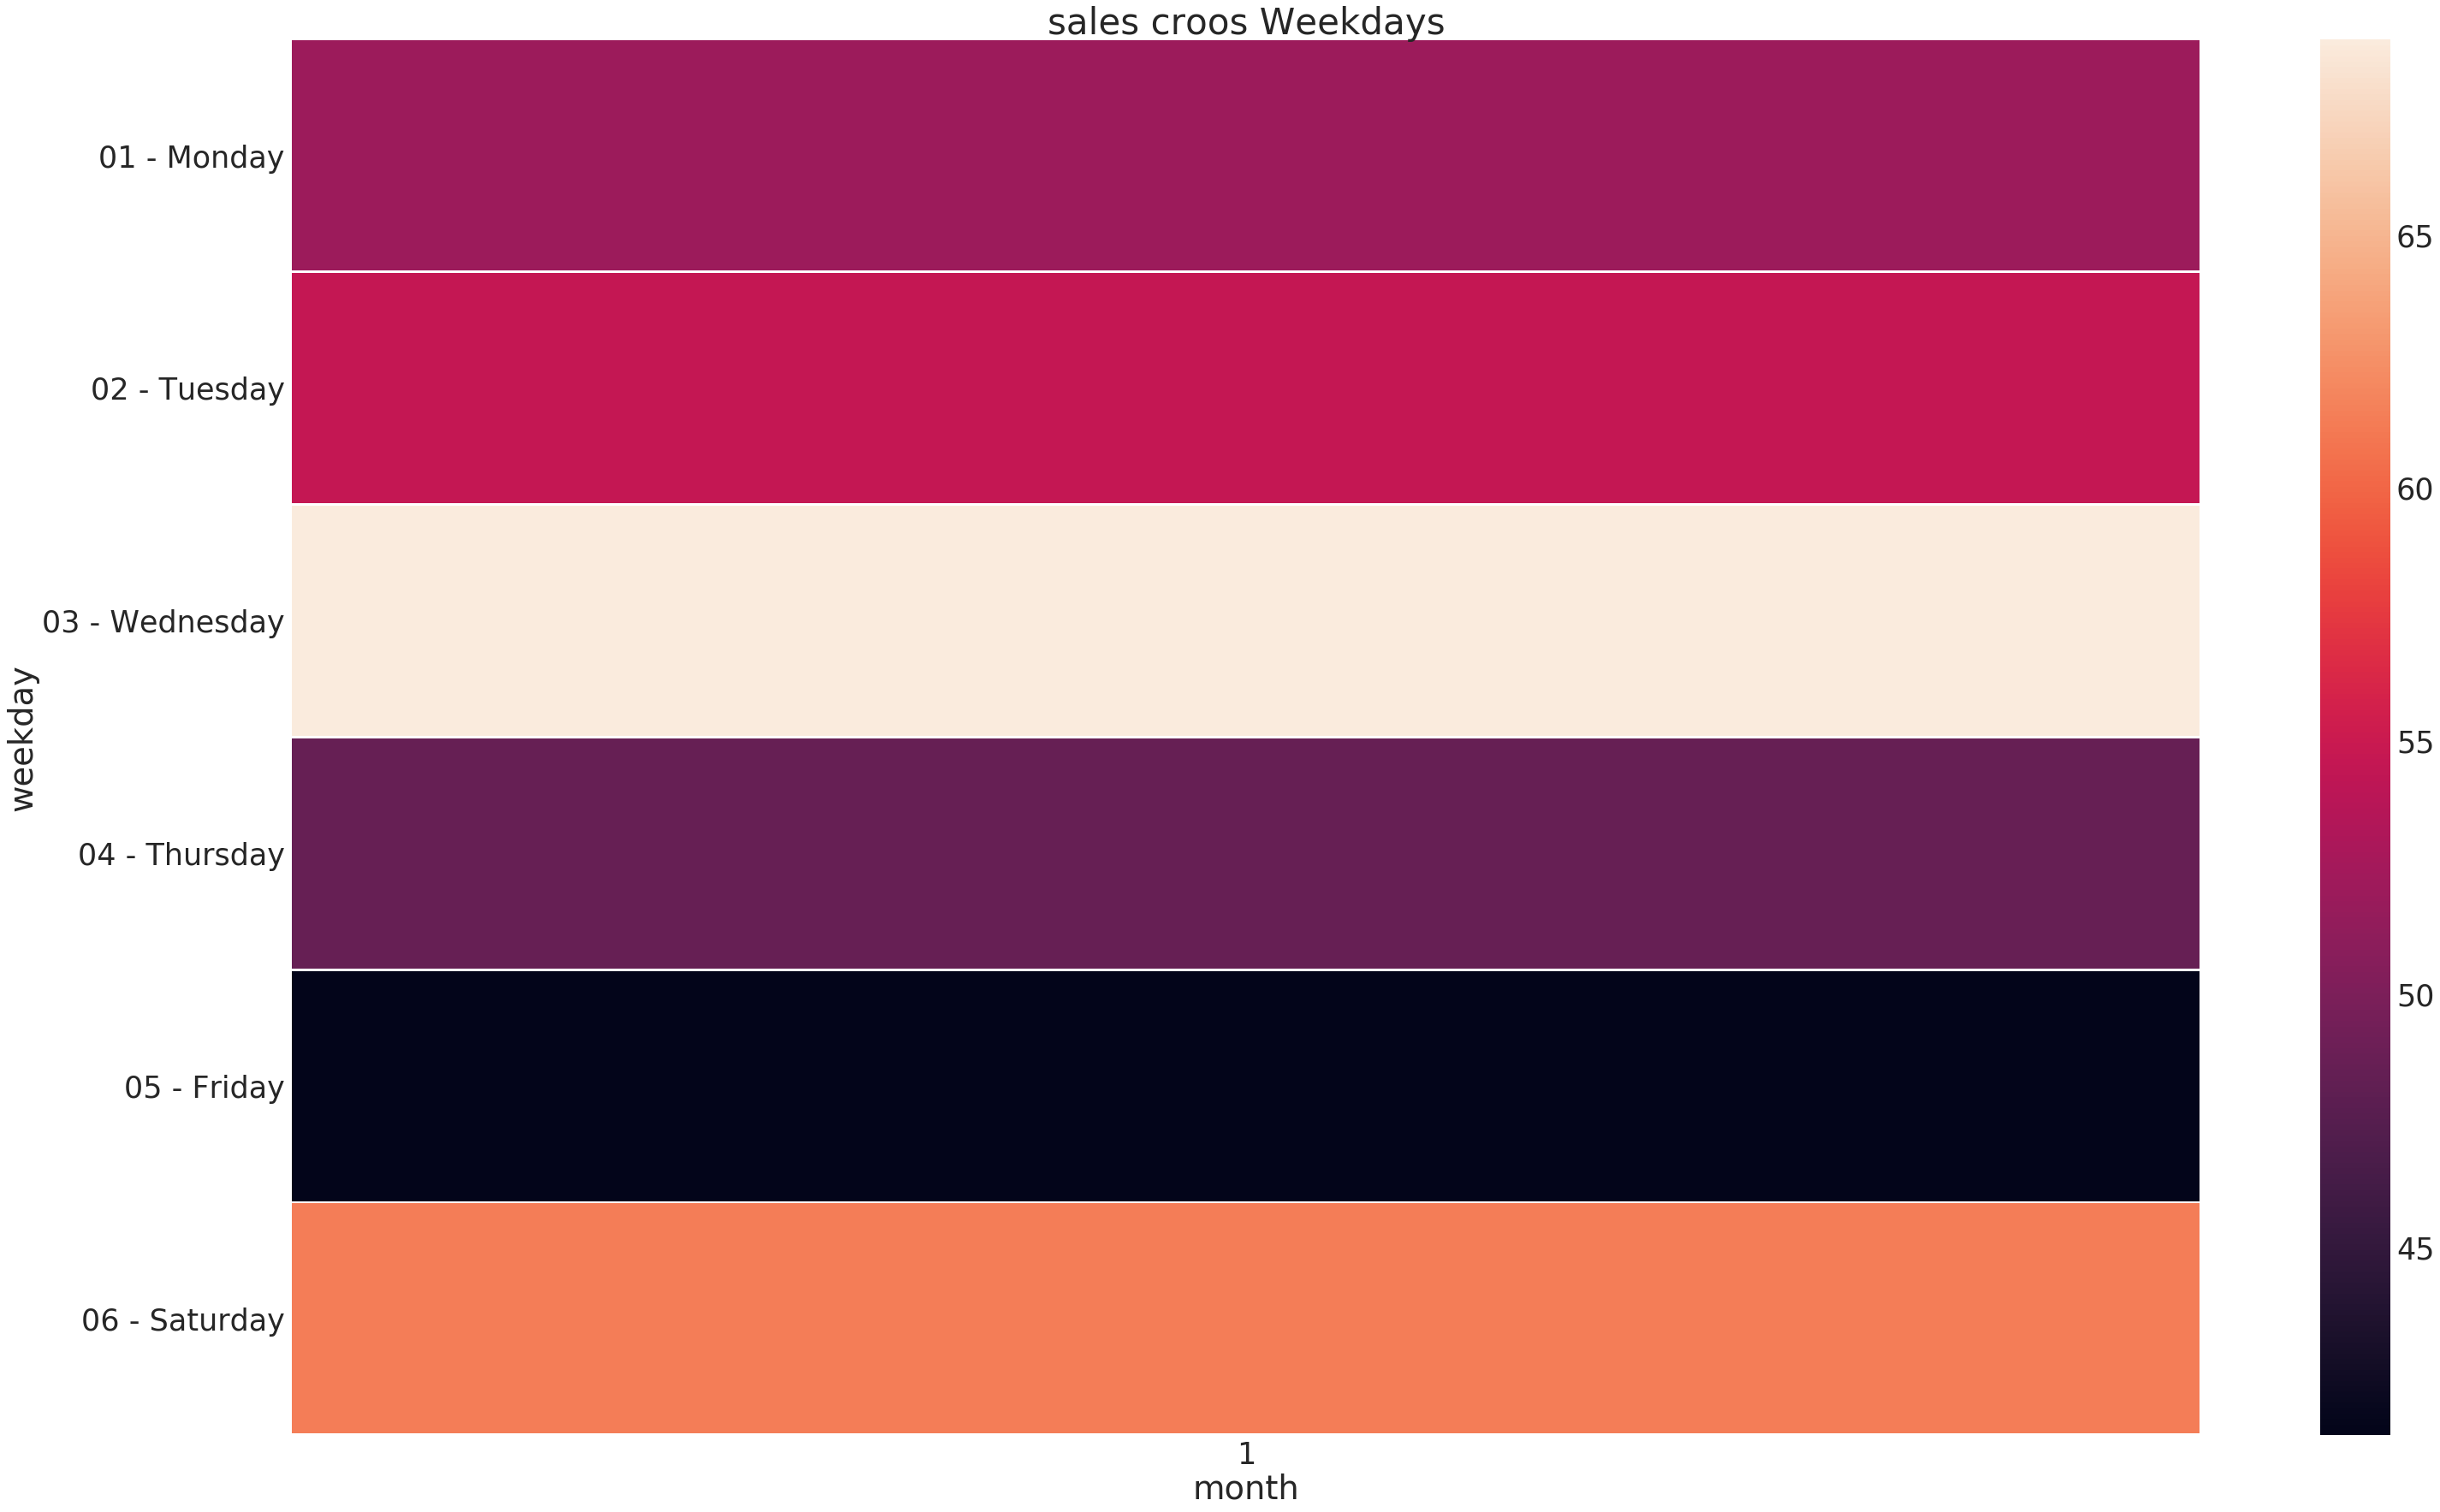

In [187]:
sns.set(font_scale=3.5) 

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(50, 30))
sns.heatmap(train_group, annot=False, ax=ax, fmt="d", linewidths=2)
plt.title('sales croos Weekdays')
plt.show()

This meatmap show us in average the sales by weekdays cross the month(january). We can see there are less activity in  Friday, Sunday days are no considered because (we assume) restaurant close. The biggest sales is on the period Monday-wednesday and SAturday. 


In [188]:
train_hour = train_flattened.groupby(["month", "hour"])['valorTotal'].sum().reset_index()
train_hour = train_hour.pivot('hour','month','valorTotal')
train_hour.sort_index(inplace=True)
train_hour.dropna(inplace=True)

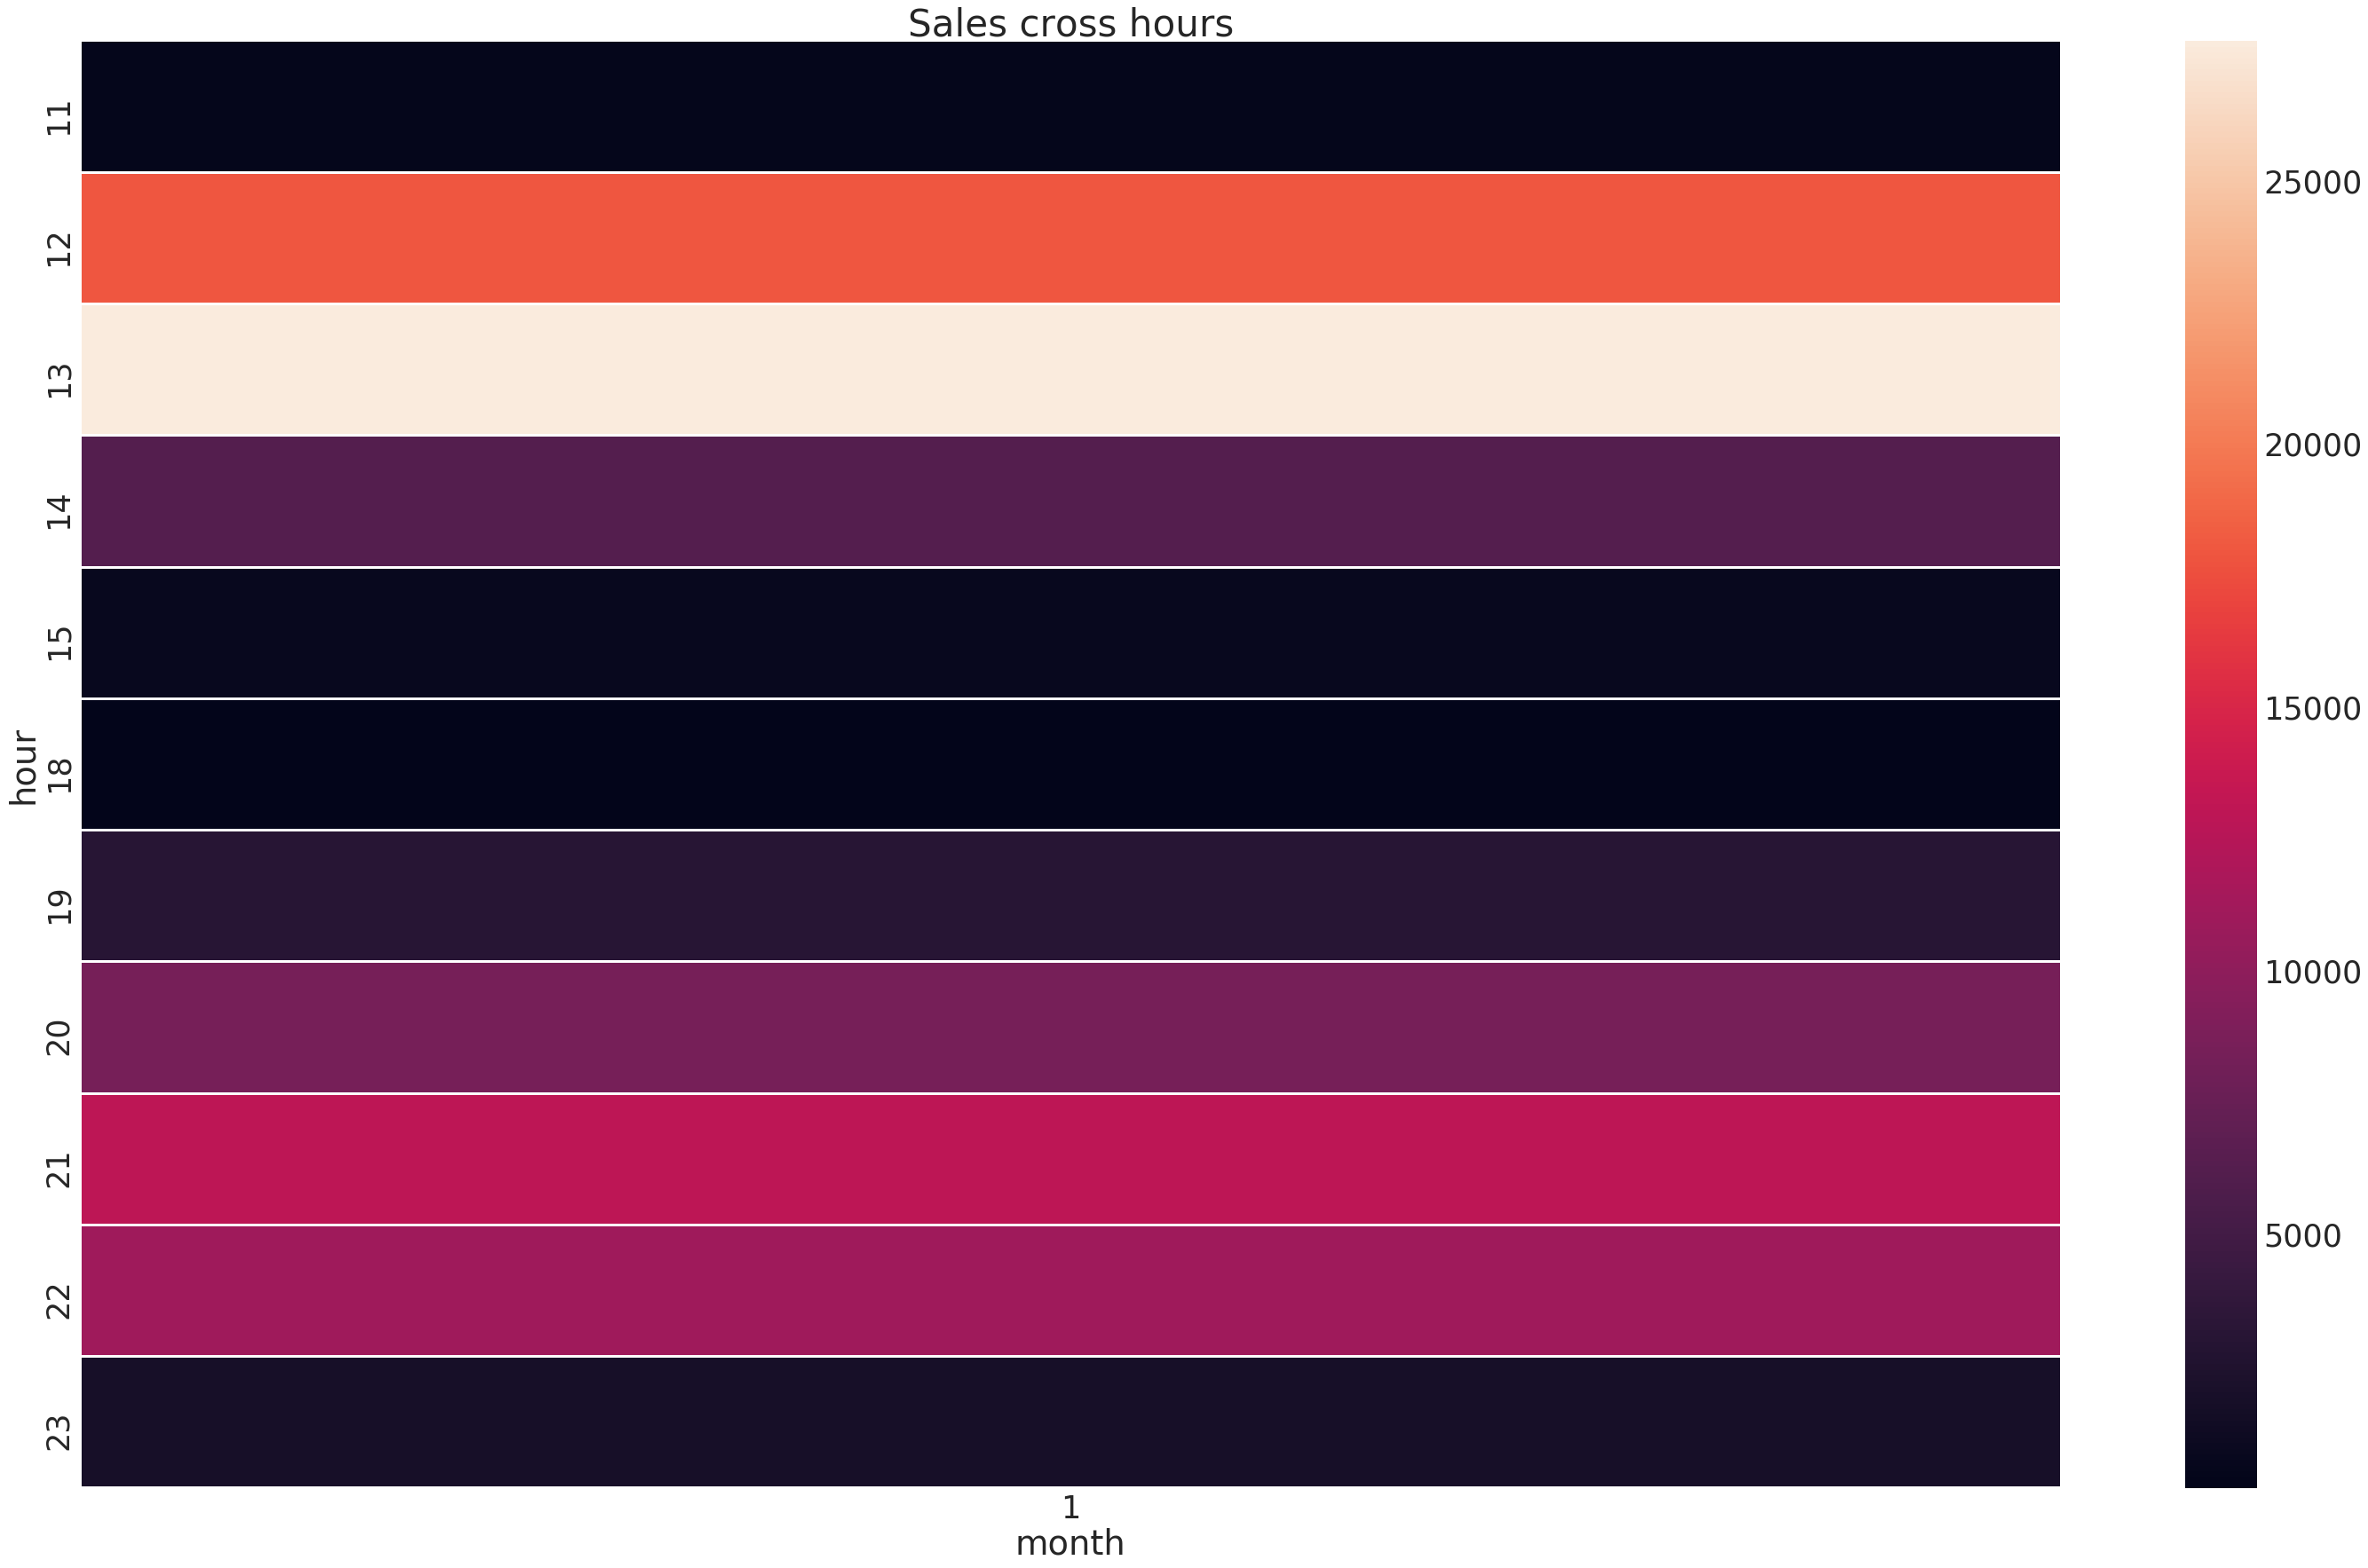

In [189]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(50, 30))
sns.heatmap(train_hour, annot=False, ax=ax, fmt="d", linewidths=2)
plt.title('Sales cross hours')
plt.show()

This graph shows two periods with bigger activity than the rest of hours. The two periods are 12-13 hours(lunch) and 20-22 hours (dinner), Also, we can see at 18h no activity is recorder, it is maybe the restaurant is closed at this time. 

                                                        III. Forecasting Approaches

In [190]:
times_series_ =  pd.DataFrame(valorhour_group).reset_index(drop=False)
times_series_['weekday'] = times_series_['dates'].apply(lambda x: x.weekday())
times_series_['Date_str'] = times_series_['dates'].apply(lambda x: str(x))
times_series_[['year','month','day']] = pd.DataFrame(times_series_['Date_str'].str.split('-',2).tolist(), columns = ['year','month','day'])
date_st = pd.DataFrame(times_series_['day'].str.split(' ',2).tolist(), columns = ['day','other'])
times_series_['day'] = date_st['day']*1
times_series_.drop('Date_str',axis = 1, inplace =True)
times_series_

,dates,valorTotal,weekday,year,month,day
0,2016-01-05,6821.34,1,2016,01,05
1,2016-01-06,7647.62,2,2016,01,06
2,2016-01-07,3225.95,3,2016,01,07
3,2016-01-08,3050.43,4,2016,01,08
4,2016-01-09,3273.54,5,2016,01,09
5,2016-01-10,0.00,6,2016,01,10
6,2016-01-11,6010.00,0,2016,01,11
7,2016-01-12,6445.67,1,2016,01,12
8,2016-01-13,9951.97,2,2016,01,13
9,2016-01-14,3235.27,3,2016,01,14


- Using Prophet: 

Prophet is a forecasting tool availaible in python and R. This tool was created by Facebook.

In [192]:
valorday_group=valorhour_group.resample('d').sum()
times_series_day =  pd.DataFrame(valorday_group).reset_index(drop=False)
times_series_day['weekday'] = times_series_day['dates'].apply(lambda x: x.weekday())
times_series_day['Date_str'] = times_series_day['dates'].apply(lambda x: str(x))
times_series_day[['year','month','day']] = pd.DataFrame(times_series_day['Date_str'].str.split('-',2).tolist(), columns = ['year','month','day'])
date_st_day = pd.DataFrame(times_series_day['day'].str.split(' ',2).tolist(), columns = ['day','other'])
times_series_day['day'] = date_st_day['day']*1
times_series_day.drop('Date_str',axis = 1, inplace =True)

# setting train data 
sns.set(font_scale=1) 
df_date_index = times_series_day[['dates','valorTotal']]
df_date_index = df_date_index.set_index('dates')
df_prophet = df_date_index.copy()
df_prophet.reset_index(drop=False,inplace=True)
df_prophet.columns = ['ds','y']


In [198]:
# fitting model 
m = Prophet() #prophet instance
m.fit(df_prophet) # fit the model with dataframe

# start forecsting with prophet
future = m.make_future_dataframe(periods=7,freq='d') # create a pandas dataframe with 7 (periods = 7) future data points with a daily frequency (freq = ‘d’)
forecast = pd.DataFrame(m.predict(future)) # forecast using the ‘predict’ command


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:n_changepoints greater than number of observations.Using 14.0.


In [199]:
# get dataframe to plot
sales_df = pd.DataFrame(columns=['ds','y_orig','y'])
sales_df['ds']    = times_series_day.dates
sales_df['y_orig']= times_series_day.valorTotal # We want to save the original data for later use
sales_df['y'] = times_series_day['valorTotal'] 

sales_df.set_index('ds', inplace=True)
forecast.set_index('ds', inplace=True)
viz_df = sales_df.join(forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
del viz_df['y']

#First, we need to get the last date in the original sales data. This will be used to split the data for plotting.
sales_df.index = pd.to_datetime(sales_df.index)
last_date = sales_df.index[-1]


In [200]:
def plot_data_prophet(func_df, end_date):
    end_date = end_date - timedelta(weeks=4) 
    mask = (func_df.index > end_date) # set up a mask to pull out the predicted rows of data.
    predict_df = func_df.loc[mask] # using the mask, we create a new dataframe with just the predicted data.
    
# plot everything
    fig, ax1 = plt.subplots(figsize=(25, 10))
    ax1.plot(sales_df.y_orig)
    ax1.plot((predict_df.yhat), color='red', linestyle=':')
    ax1.fill_between(predict_df.index, predict_df['yhat_upper'], predict_df['yhat_lower'], alpha=0.5, color='darkgray')
    ax1.set_title('Sales (Blue) vs Sales Forecast (Red)')
    ax1.set_ylabel('Sales (R$)')
    ax1.set_xlabel('Date')
    
# change size font
    ax1.tick_params(axis='both',which='both',labelsize='large')
  
# change the legend text
    L=ax1.legend(fontsize='large') #get the legend
    L.get_texts()[0].set_text('Actual Sales') #change the legend text for 1st plot
    L.get_texts()[1].set_text('Forecasted Sales') #change the legend text for 2nd plot


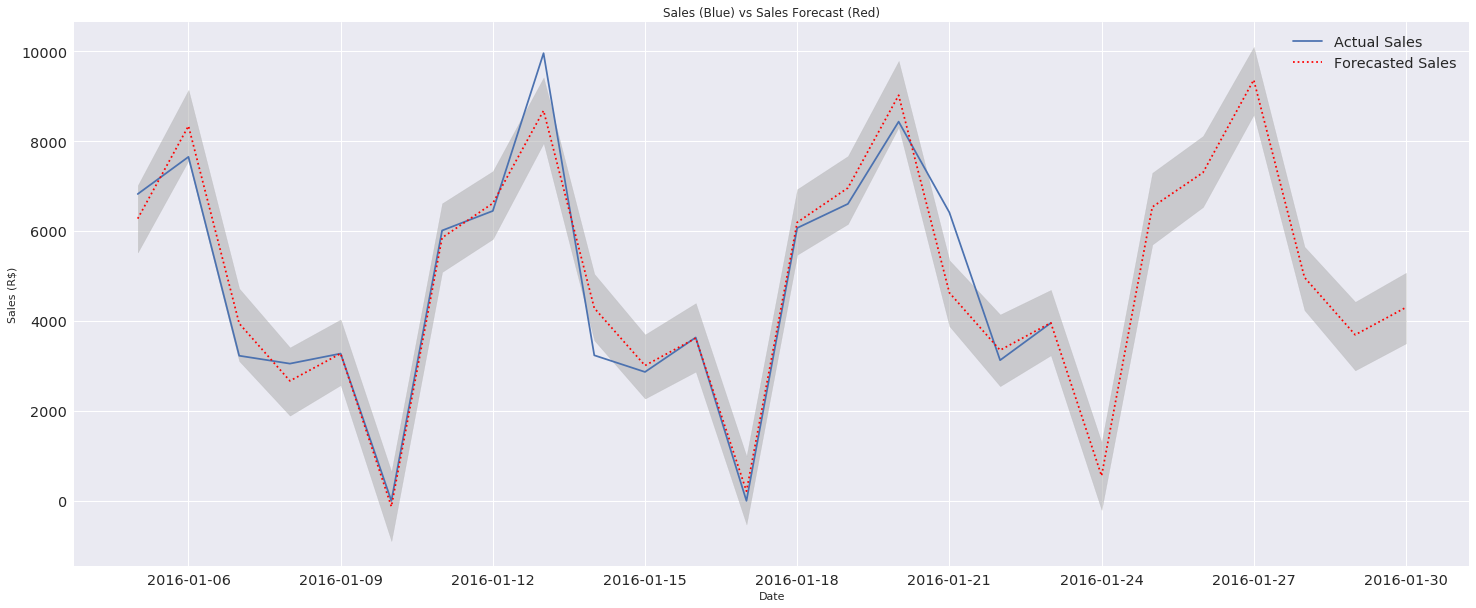

In [201]:
plot_data_prophet(viz_df,last_date)

The graph above allows to get an understanding of how well our model is working. That looks pretty good, we’ve been able to quickly model and forecast some data to get a feel for what might be coming our way in the future (one week) from this particular data set. However,  prophet still doesn't support hourly time series forecasting.


- Using Keras:

In order to support hourly time series forecasting, we will use Keras to forecast. It is just a very simple code to begin with Keras and a Time Series. For our model we will try just with one layer and 48 Neurons.

In [277]:
# we need to define some util function

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1): # look_back represents  lags needed to create the RNN inputs
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# for sanity in Neural Networks, we need transform features by scaling each feature to  range [0 1]. 
scaler = MinMaxScaler(feature_range=(0, 1))

# Before we can do any analysis with this data, we need to log transform the ‘y’ variable: (at above step when using "prophet" approach we don't needed this step  
# This isn’t always a perfect way to handle time-series data, but it works often enough that it can be tried initially without much worry.

# normalize dataset and/or log transform 
def fit_transform_log(dataset, log=0):
  
  constant = 1.0 # constant value is needed because zero values are present in dataset
  dataTrans = []
  if log==1:
    dataTrans = np.log10(constant+dataset)
    dataTrans = scaler.fit_transform(dataTrans)
  else:
    dataTrans = scaler.fit_transform(dataset)
  
  return dataTrans

# inverse dataset and log transform 
def fit_detransform_log(dataset, log=0):
  
  constant = 1.0
  datadeTrans = []
  if log==1:
    datadeTrans = scaler.inverse_transform(dataset)
    datadeTrans = np.power(10,datadeTrans)-constant
  else:
    datadeTrans = scaler.inverse_transform(dataset)
  
  return datadeTrans

# plot by timestamp
def plot_by_time(date_ini,datasetlogNorm,w,h):
  # plot baseline and predictions
  plt.rc('axes', grid=True)
  plt.rc('figure', figsize=(w, h))
  plt.rc('legend', fancybox=True, framealpha=1)
  
  times = pd.date_range(date_ini, periods=len(datasetlogNorm), freq='1h')
  fig, ax = plt.subplots(1)
  fig.autofmt_xdate()
  ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(date_ini.hour,24,3)))
  ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%m\n%d\n%a'))
  ax.xaxis.grid(True, which="minor")
  ax.xaxis.set_major_locator(mdates.MonthLocator())
  ax.xaxis.set_major_formatter(mdates.DateFormatter('\n\n\n%b\n%Y'))
  ax.tick_params(axis='both',which='minor',labelsize=7)
  ax.set_ylabel('Sales (R$)')
  ax.set_xlabel('Date by hour')
  return fig,times
  
  

In [278]:
# load dataset samples
with open('sample.txt') as f:
    d=json.load(f)
    
    
dt1=json_normalize(data=d)
dt1.columns=dt1.columns.map(lambda x:x.split(".")[-1])
dt1=dt1.rename(columns = {'$date':'dates','$numberLong':'numberLong'})

# count records by days
dt1['dates']=pd.to_datetime(dt1['dates'])
dateINI=dt1['dates'][0]

# set index date time 
dt1.index=dt1['dates']
del dt1['dates']

#resume by hour , sales fiscal
dt1_ts=dt1.resample('H').sum()

# We can then extract the NumPy array from the dataframe and convert the integer 
# values to floating point values, which are more suitable for modeling with a neural network.
dataset = dt1_ts['valorTotal'].values
dataset = dataset.astype('float32')

In [279]:
# We start normalizing the dataset
log_value=1  # flag, it permits to run the model with log-transformed data "1" or non-log "0" 

datasetlogNorm = np.reshape(dataset,(-1,1))
datasetlogNorm = fit_transform_log(datasetlogNorm,log_value)

# split into train and test sets
train_size = int(len(datasetlogNorm) * 0.80) # 80% of training data and 20% of test
test_size = len(datasetlogNorm) - train_size
train, test = datasetlogNorm[0:train_size,:], datasetlogNorm[train_size:len(datasetlogNorm),:]

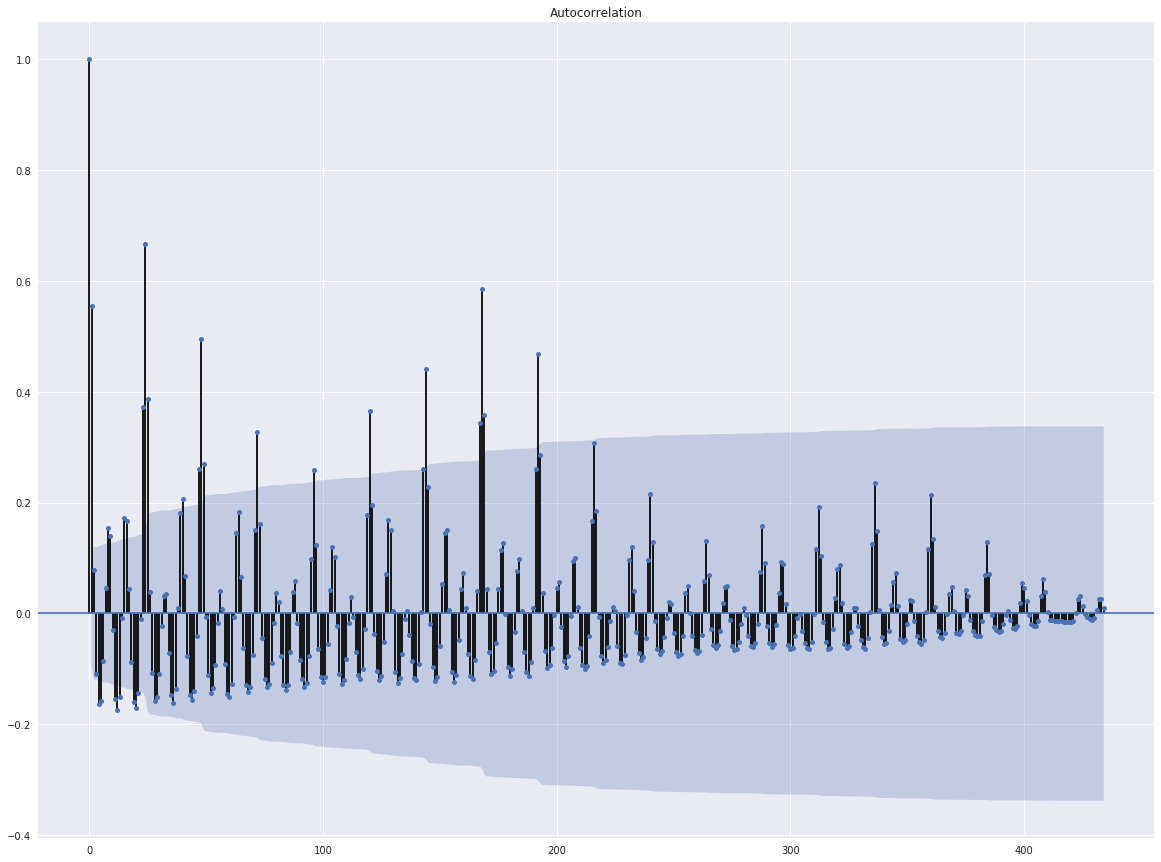

In [280]:
# In order to get an initial idea of lag values, we can plot  the  autocorrelation coefficients function
plot_acf(dataset)
plt.show()

In [281]:
# Based on the graphic above,  after we have tried with different values, we considered 24-lag value is better

# reshape into X=t and Y=t+look_back
look_back = 24
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
testX

array([[0.        , 0.        , 0.        , ..., 0.9207564 , 0.975145  ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.975145  , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.50841236, 0.9526042 , 0.913601  , ..., 0.        , 0.        ,
        0.        ],
       [0.9526042 , 0.913601  , 0.52598906, ..., 0.        , 0.        ,
        0.633674  ],
       [0.913601  , 0.52598906, 0.4464884 , ..., 0.        , 0.633674  ,
        0.87770146]], dtype=float32)

In [282]:
# we need to reshape input to be [samples, time steps, features], (for neural network input)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [262]:
# create and fit the LSTM network
model = Sequential() # instance of Sequential model
model.add(LSTM(48, input_shape=(1, look_back))) # configure number of neurons = 48
model.add(Dense(1)) 
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2) #set epochs and fit the model


Epoch 1/100
 - 4s - loss: 0.0871
Epoch 2/100
 - 2s - loss: 0.0483
Epoch 3/100
 - 3s - loss: 0.0406
Epoch 4/100
 - 2s - loss: 0.0376
Epoch 5/100
 - 3s - loss: 0.0350
Epoch 6/100
 - 3s - loss: 0.0335
Epoch 7/100
 - 3s - loss: 0.0305
Epoch 8/100
 - 3s - loss: 0.0307
Epoch 9/100
 - 3s - loss: 0.0299
Epoch 10/100
 - 2s - loss: 0.0288
Epoch 11/100
 - 2s - loss: 0.0282
Epoch 12/100
 - 2s - loss: 0.0269
Epoch 13/100
 - 2s - loss: 0.0267
Epoch 14/100
 - 2s - loss: 0.0259
Epoch 15/100
 - 2s - loss: 0.0253
Epoch 16/100
 - 2s - loss: 0.0246
Epoch 17/100
 - 2s - loss: 0.0256
Epoch 18/100
 - 2s - loss: 0.0244
Epoch 19/100
 - 2s - loss: 0.0242
Epoch 20/100
 - 2s - loss: 0.0243
Epoch 21/100
 - 2s - loss: 0.0240
Epoch 22/100
 - 2s - loss: 0.0240
Epoch 23/100
 - 2s - loss: 0.0235
Epoch 24/100
 - 2s - loss: 0.0230
Epoch 25/100
 - 2s - loss: 0.0227
Epoch 26/100
 - 2s - loss: 0.0228
Epoch 27/100
 - 2s - loss: 0.0220
Epoch 28/100
 - 2s - loss: 0.0225
Epoch 29/100
 - 2s - loss: 0.0218
Epoch 30/100
 - 2s - lo

In [283]:
# getting train and test scores
trainForest= model.predict(trainX)
testForest = model.predict(testX)

# invert log-transform
trainForest = fit_detransform_log(trainForest,log_value)
trainY = fit_detransform_log([trainY],log_value)
testForest = fit_detransform_log(testForest,log_value)
testY = fit_detransform_log([testY],log_value)

#calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainForest[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testForest[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 269.47 RMSE
Test Score: 236.95 RMSE


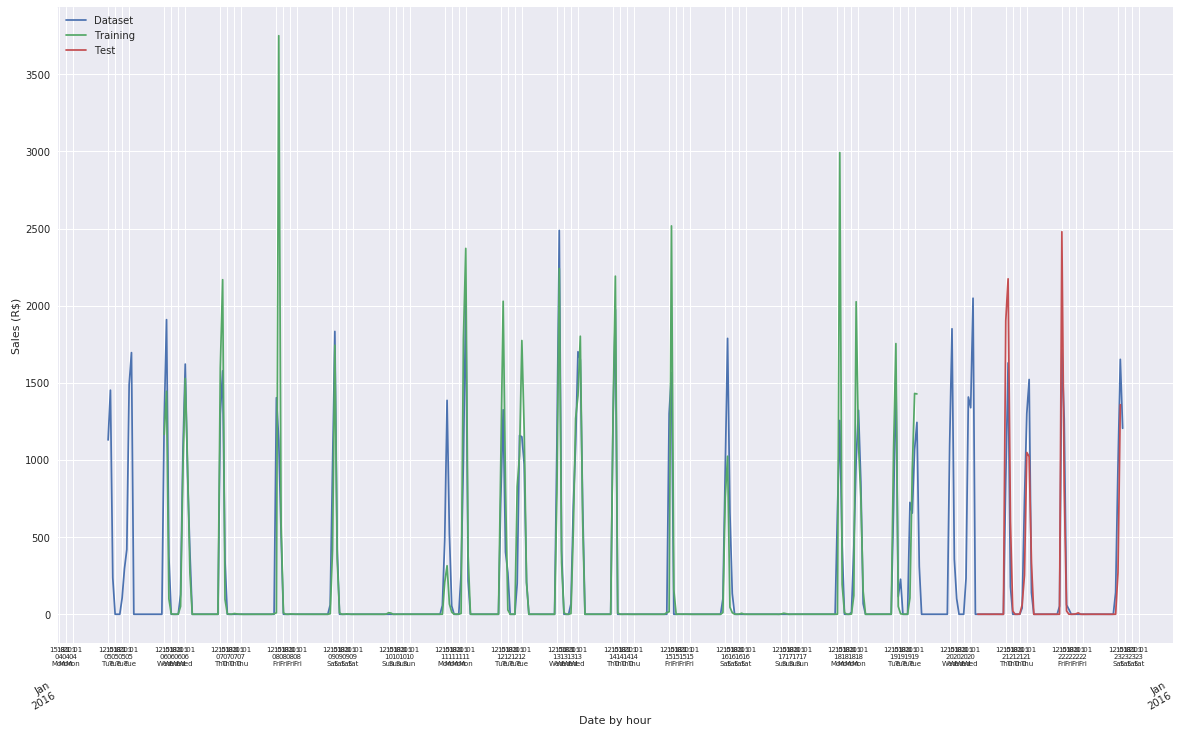

In [284]:
# plot training and test values 
trainPredictPlot = np.empty_like(datasetlogNorm)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainForest)+look_back, :] = trainForest

# shift test predictions for plotting
testPredictPlot = np.empty_like(datasetlogNorm)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainForest)+(look_back*2)+1:len(datasetlogNorm)-1, :] = testForest

# 
figg,times= plot_by_time(dateINI,datasetlogNorm,20,13)
plt.plot(times,fit_detransform_log(datasetlogNorm,log_value),label="Dataset")
plt.plot(times,trainPredictPlot,label="Training")
plt.plot(times,testPredictPlot,label="Test")
plt.legend(loc='upper left')
plt.show()

The graph above allows getting an understanding of how well our model is working. That looks not very good. However, we believe that weekly seasonal values(zero values) such Sunday affects the model.  

In [285]:
# forecasting by weeks
weeks=1 # aprox number of week forecasting 
hours_x_axis=24*7*weeks # aprox number of hour by weeks

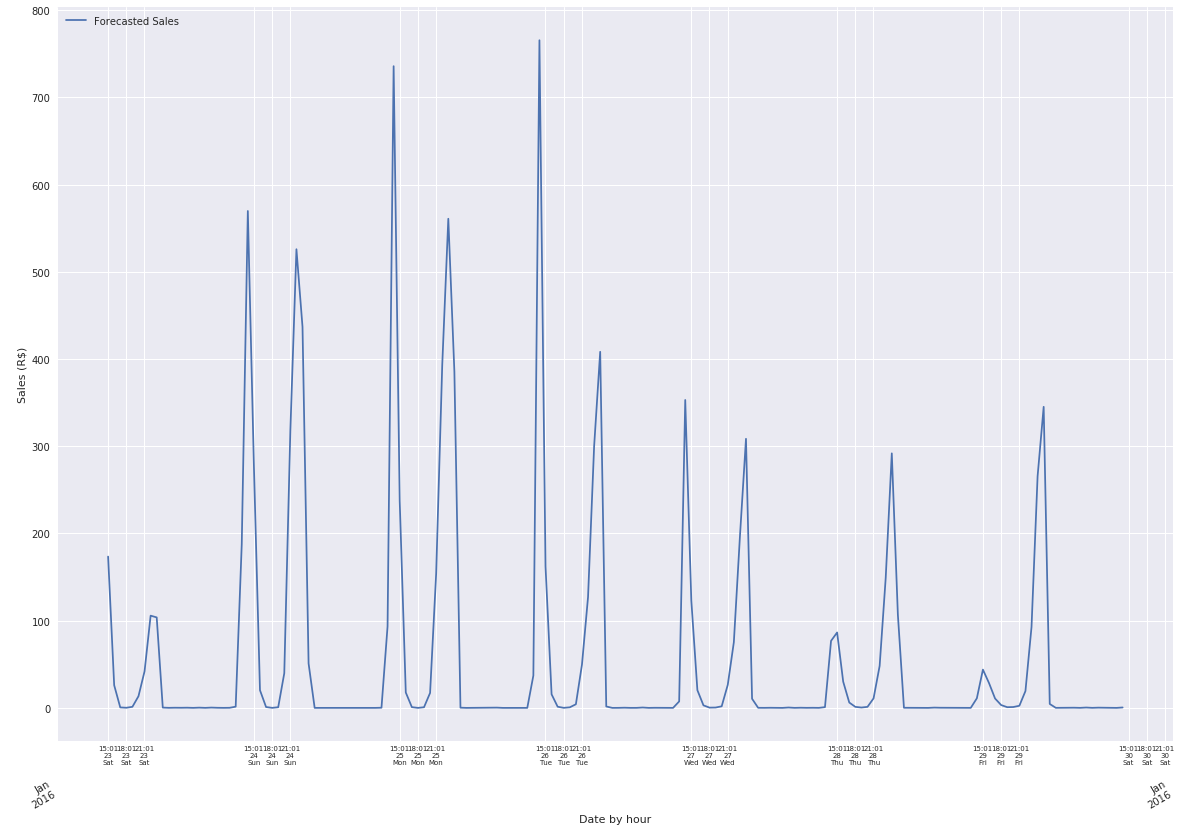

In [286]:
# getting test portion 
data_t=np.empty(shape=(len(testX),1))

# first, pass through all test data
for i in range(0,len(testX)):
  input_hour1 = testX[i,0]
  input_hour1 = np.reshape(input_hour1, (1, 1, look_back))
  yhat1 = np.absolute(model.predict(input_hour1))
  data_t[i] = [yhat1]
    
# set the last element of dataset or "test" 
data_t_generate=np.empty(shape=(hours_x_axis,1))
input_hour=np.append(input_hour1,[yhat1])
input_hour=np.delete(input_hour,0)

# Second, We forecast the following (24*7*weeks) hours  
for i in range(0,hours_x_axis):
    input_hour = np.reshape(input_hour, (1, 1, look_back))
    yhat = np.absolute(model.predict(input_hour))
    data_t_generate[i]=[yhat]
    input_hour=np.append(input_hour,[yhat])
    input_hour=np.delete(input_hour,0)

input_hour_forest=data_t_generate
figg2,times2= plot_by_time(times[len(times)-1]+pd.Timedelta(hours=1),input_hour_forest,20,15)
plt.plot(times2,fit_detransform_log(input_hour_forest,log_value),label="Forecasted Sales")
plt.legend(loc='upper left')
plt.show()

Given that we have such little data.  We can check in the model (an LSTM network) with hourly timesteps, that the seasonal zero values(Sunday) affect the forecast. However, the behavior present in the historical data is maintaine, the bigger activity in two periods 12-13 hours(lunch) and 20-22 hours (dinner).

Finally, the "prophet" forecast in daily timesteps compared to this method, this one is faster. We can forecast a time series with few lines.  

